In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array
from sklearn.exceptions import NotFittedError
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
import warnings

warnings.filterwarnings('ignore')

# ---------------------- Custom Ensemble Model ---------------------- #
class LightGBM_MLP_Ensemble(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.lgbm = LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
        self.mlp = MLPClassifier(hidden_layer_sizes=(128, 64, 32), activation='relu', alpha=1e-4,
                                 max_iter=600, early_stopping=True, random_state=42)
        self.meta_clf = MLPClassifier(hidden_layer_sizes=(16,), max_iter=300, random_state=42)
        self.is_fitted_ = False

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.lgbm.fit(X, y)
        self.mlp.fit(X, y)
        lgbm_out = self.lgbm.predict_proba(X)
        mlp_out = self.mlp.predict_proba(X)
        fused = np.hstack([lgbm_out, mlp_out])
        self.meta_clf.fit(fused, y)
        self.is_fitted_ = True
        return self

    def predict(self, X):
        self._check_is_fitted()
        X = check_array(X)
        lgbm_out = self.lgbm.predict_proba(X)
        mlp_out = self.mlp.predict_proba(X)
        fused = np.hstack([lgbm_out, mlp_out])
        return self.meta_clf.predict(fused)

    def predict_proba(self, X):
        self._check_is_fitted()
        X = check_array(X)
        lgbm_out = self.lgbm.predict_proba(X)
        mlp_out = self.mlp.predict_proba(X)
        return self.meta_clf.predict_proba(np.hstack([lgbm_out, mlp_out]))

    def _check_is_fitted(self):
        if not self.is_fitted_:
            raise NotFittedError("Model is not fitted yet.")

# ---------------------- Pipeline Steps ---------------------- #
def load_data(filename):
    return pd.read_csv(filename) if filename.endswith(".csv") else pd.read_excel(filename)

def preprocess_data(df):
    selected_columns = ['time', 'trt', 'age', 'wtkg', 'hemo', 'homo', 'drugs',
                        'karnof', 'oprior', 'z30', 'preanti', 'race', 'gender',
                        'str2', 'strat', 'symptom', 'treat', 'offtrt', 'cd40',
                        'cd420', 'cd80', 'cd820', 'infected']
    df = df[selected_columns]
    df = df.dropna(subset=['infected'])
    df.fillna(df.mean(numeric_only=True), inplace=True)
    return df

def encode_categorical_features(X, categorical_columns):
    for col in categorical_columns:
        if col in X.columns:
            X[col] = LabelEncoder().fit_transform(X[col])
    return X


def scale_features(X):
    scaler = StandardScaler()
    return scaler.fit_transform(X)

def apply_smote(X_train, y_train):
    smote = SMOTE(random_state=42)
    return smote.fit_resample(X_train, y_train)

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n✅ Accuracy: {accuracy:.4f}")
    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred))
    print("\n🧱 Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

# ---------------------- Main Entry Point ---------------------- #
def main():
    filename = "/content/AIDS_Classification.csv"  # Update if needed
    df = load_data(filename)

    df = preprocess_data(df)
    X = df.drop(columns=['infected'])
    y = df['infected']

    categorical_columns = ['race', 'gender', 'drugs', 'symptom', 'treat']
    X = encode_categorical_features(X, categorical_columns)

    # Feature engineering disabled for now
    # X = engineer_features(X)

    X_scaled = scale_features(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=42)
    X_train_res, y_train_res = apply_smote(X_train, y_train)

    print("\n🚀 LightGBM + MLP Ensemble Results")
    model = LightGBM_MLP_Ensemble()
    train_and_evaluate_model(model, X_train_res, y_train_res, X_test, y_test)

if __name__ == "__main__":
    main()



🚀 LightGBM + MLP Ensemble Results
[LightGBM] [Info] Number of positive: 1132, number of negative: 1132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2582
[LightGBM] [Info] Number of data points in the train set: 2264, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

✅ Accuracy: 0.8925

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       486
           1       0.80      0.75      0.77       156

    accuracy                           0.89       642
   macro avg       0.86      0.84      0.85       642
weighted avg       0.89      0.89      0.89       642


🧱 Confusion Matrix:
[[456  30]
 [ 39 117]]


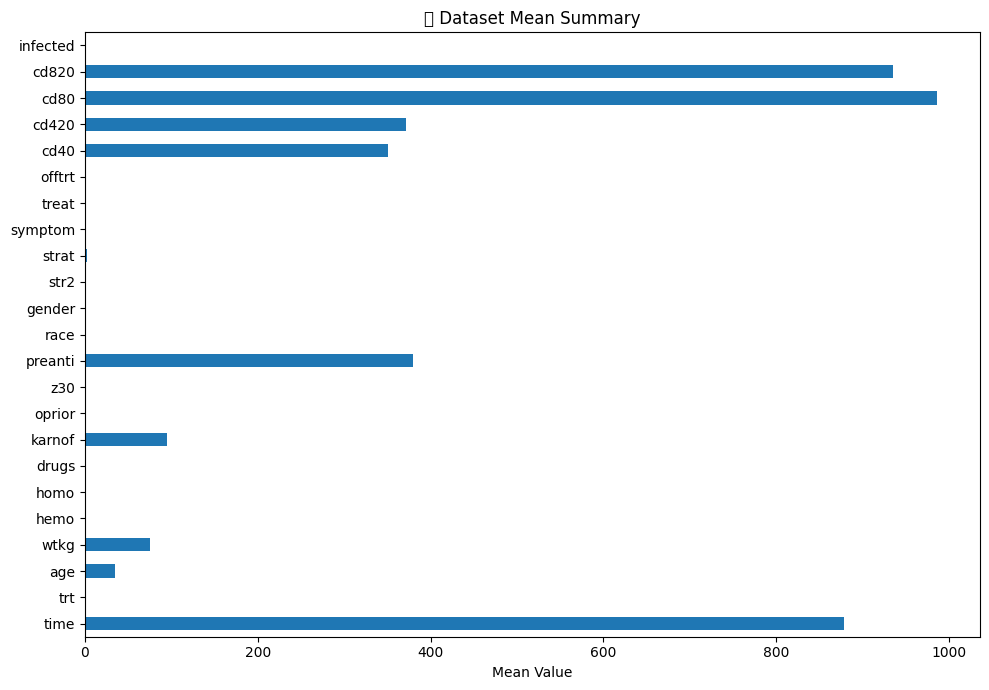

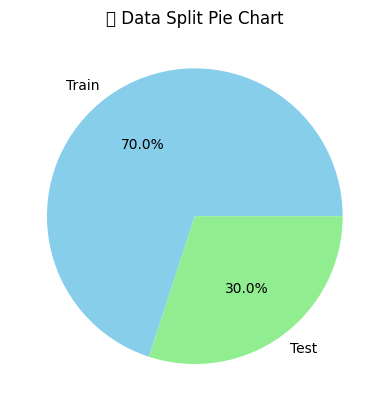


🚀 LightGBM + MLP Ensemble Results
[LightGBM] [Info] Number of positive: 1132, number of negative: 1132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2582
[LightGBM] [Info] Number of data points in the train set: 2264, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

✅ Accuracy: 0.8925
⚖️ Balanced Accuracy: 0.8441

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       486
           1       0.80      0.75      0.77       156

    accuracy                           0.89       642
   macro avg       0.86      0.84      0.85       642
weighted avg       0.89      0.89      0.89       642



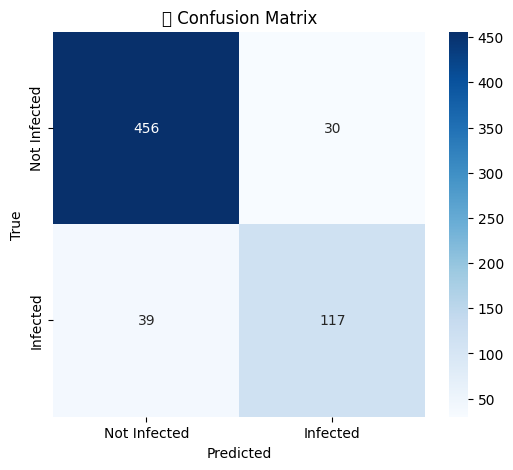

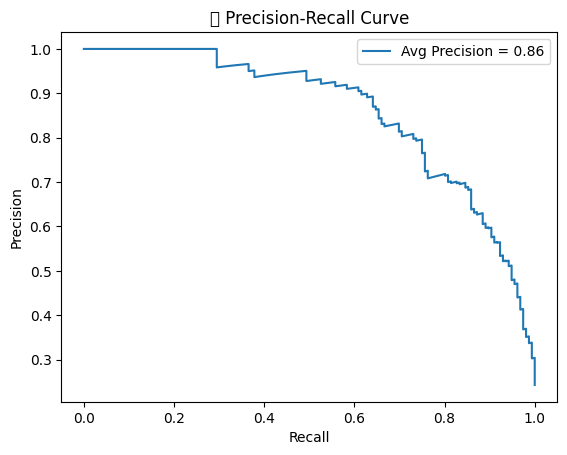


🔁 10-Fold Cross-Validation:
[LightGBM] [Info] Number of positive: 1019, number of negative: 1018
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2542
[LightGBM] [Info] Number of data points in the train set: 2037, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500245 -> initscore=0.000982
[LightGBM] [Info] Start training from score 0.000982
[LightGBM] [Info] Number of positive: 1019, number of negative: 1018
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2536
[LightGBM] [Info] Number of data points in the train set: 2037, number of used features: 

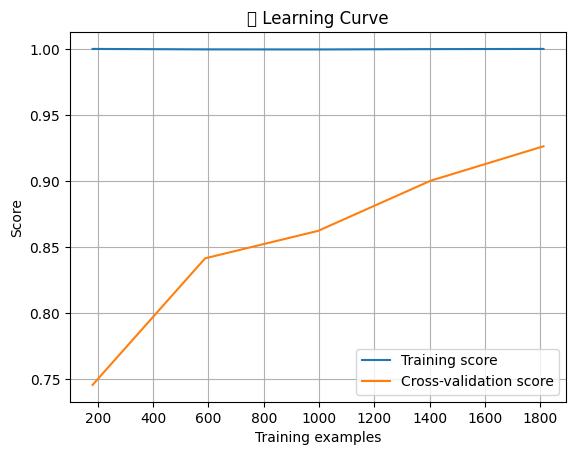

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             precision_recall_curve, average_precision_score,
                             balanced_accuracy_score)

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array
from sklearn.exceptions import NotFittedError
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

# ---------------------- Custom Ensemble Model ---------------------- #
class LightGBM_MLP_Ensemble(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.lgbm = LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
        self.mlp = MLPClassifier(hidden_layer_sizes=(128, 64, 32), activation='relu', alpha=1e-4,
                                 max_iter=600, early_stopping=True, random_state=42)
        self.meta_clf = MLPClassifier(hidden_layer_sizes=(16,), max_iter=300, random_state=42)
        self.is_fitted_ = False

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.lgbm.fit(X, y)
        self.mlp.fit(X, y)
        lgbm_out = self.lgbm.predict_proba(X)
        mlp_out = self.mlp.predict_proba(X)
        fused = np.hstack([lgbm_out, mlp_out])
        self.meta_clf.fit(fused, y)
        self.is_fitted_ = True
        return self

    def predict(self, X):
        self._check_is_fitted()
        X = check_array(X)
        lgbm_out = self.lgbm.predict_proba(X)
        mlp_out = self.mlp.predict_proba(X)
        fused = np.hstack([lgbm_out, mlp_out])
        return self.meta_clf.predict(fused)

    def predict_proba(self, X):
        self._check_is_fitted()
        X = check_array(X)
        lgbm_out = self.lgbm.predict_proba(X)
        mlp_out = self.mlp.predict_proba(X)
        return self.meta_clf.predict_proba(np.hstack([lgbm_out, mlp_out]))

    def _check_is_fitted(self):
        if not self.is_fitted_:
            raise NotFittedError("Model is not fitted yet.")

# ---------------------- Helper Functions ---------------------- #
def load_data(filename):
    return pd.read_csv(filename) if filename.endswith(".csv") else pd.read_excel(filename)

def preprocess_data(df):
    selected_columns = ['time', 'trt', 'age', 'wtkg', 'hemo', 'homo', 'drugs',
                        'karnof', 'oprior', 'z30', 'preanti', 'race', 'gender',
                        'str2', 'strat', 'symptom', 'treat', 'offtrt', 'cd40',
                        'cd420', 'cd80', 'cd820', 'infected']
    df = df[selected_columns]
    df = df.dropna(subset=['infected'])
    df.fillna(df.mean(numeric_only=True), inplace=True)
    return df

def encode_categorical_features(X, categorical_columns):
    for col in categorical_columns:
        if col in X.columns:
            X[col] = LabelEncoder().fit_transform(X[col])
    return X

def scale_features(X):
    scaler = StandardScaler()
    return scaler.fit_transform(X)

def apply_smote(X_train, y_train):
    smote = SMOTE(random_state=42)
    return smote.fit_resample(X_train, y_train)

def plot_confusion(cm, classes):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("🧱 Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def plot_precision_recall_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    avg_prec = average_precision_score(y_true, y_scores)
    plt.figure()
    plt.plot(recall, precision, label=f"Avg Precision = {avg_prec:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("📈 Precision-Recall Curve")
    plt.legend()
    plt.show()

def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, scoring='accuracy', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
    )
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, train_mean, label="Training score")
    plt.plot(train_sizes, test_mean, label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.title("📚 Learning Curve")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

def plot_data_split(y_train, y_test):
    sizes = [len(y_train), len(y_test)]
    labels = ['Train', 'Test']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['skyblue', 'lightgreen'])
    plt.title("📊 Data Split Pie Chart")
    plt.show()

def plot_dataset_description(df):
    df.describe().T['mean'].plot(kind='barh', figsize=(10, 7), title="📌 Dataset Mean Summary")
    plt.xlabel("Mean Value")
    plt.tight_layout()
    plt.show()

# ---------------------- Model Training & Evaluation ---------------------- #
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n✅ Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"⚖️ Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plot_confusion(cm, classes=['Not Infected', 'Infected'])
    plot_precision_recall_curve(y_test, y_proba)

    # Cross-Validation Scores
    print("\n🔁 10-Fold Cross-Validation:")
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    print(f"Mean Accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

    plot_learning_curve(model, X_train, y_train)

# ---------------------- Main Entry Point ---------------------- #
def main():
    filename = "/content/AIDS_Classification.csv"  # Update path as needed
    df = load_data(filename)

    plot_dataset_description(df)

    df = preprocess_data(df)
    X = df.drop(columns=['infected'])
    y = df['infected']

    categorical_columns = ['race', 'gender', 'drugs', 'symptom', 'treat']
    X = encode_categorical_features(X, categorical_columns)
    X_scaled = scale_features(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=42)
    plot_data_split(y_train, y_test)

    X_train_res, y_train_res = apply_smote(X_train, y_train)


    print("\n🚀 LightGBM + MLP Ensemble Results")
    model = LightGBM_MLP_Ensemble()
    train_and_evaluate_model(model, X_train_res, y_train_res, X_test, y_test)

if __name__ == "__main__":
    main()
